This file is to try SBI_SGM 

And I train model with a general connectome.


### import and define

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../mypkg'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Other pkgs

In [3]:
from tqdm import trange, tqdm

import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils as sutils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from torch.distributions.multivariate_normal import MultivariateNormal

import numpy as np
import xarray as xr
from easydict import EasyDict as edict
from pathlib import Path
import pickle
import scipy

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
from functools import partial

import warnings
warnings.filterwarnings("ignore")

#### My own pkgs

In [4]:
import importlib

import utils.misc
importlib.reload(utils.misc);
from utils.misc import mag2db, meg_psd2spatialfeature, save_pkl_dict2folder, load_pkl_folder2dict, get_mode

import utils.standardize
importlib.reload(utils.standardize);
from utils.standardize import stdz_psd, stdz_vec, minmax_vec, psd_2tr

import utils.brain_plot
importlib.reload(utils.brain_plot)
from utils.brain_plot import U2BrainVec, reorderU 

import utils.reparam
importlib.reload(utils.reparam)
from utils.reparam import theta_raw_2out, normcdf_np, normcdf_torch, logistic_np, logistic_torch

import utils.stable
importlib.reload(utils.stable)
from utils.stable import paras_table_check

import sgm.sgm
importlib.reload(sgm.sgm);
from sgm.sgm import SGM


from spectrome import Brain, path, functions

import features.psm
importlib.reload(features.psm)
from features.psm import obt_psm_fs, obt_psm_raw

import constants
importlib.reload(constants)
from constants import RES_ROOT, FIG_ROOT, DAT_ROOT

import models.embedding_nets 
importlib.reload(models.embedding_nets)
from models.embedding_nets import SummaryNet

import sgm.data_gen 
importlib.reload(sgm.data_gen)
from sgm.data_gen import simulator_data

In [5]:
#torch.set_default_tensor_type(torch.DoubleTensor)

### Load real data PSD and brain

#### PSD and connectome

In [6]:
# Load data
ind_psd_xr = xr.open_dataarray(DAT_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
FREQS = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray(DAT_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

#### Set up Parameters

In [18]:
# some constant parameters for this file
paras = edict()
#bnds = ((5.0,30.0), (5.0,200.0), (0.1,1.0), (5, 20), (0.001,0.7), (0.001,2.0), (5.0,30.0))
#Bounds for taue, taui, alpha, speed, gei, gii, tauC
# (0.001,0.7), (0.001,2.0) when considering stable checking.
# (0.001,0.5), (0.001,1.5) as safe (narrower) bounds

# taue, taui, tauC, speed, alpha, gii, gei
paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["Taue", "Taui", "TauC", "Speed", "alpha", "gii", "gei"]

paras.noise_sd = 0.20
paras.num_prior_sps = int(1e5)
paras.den_est = "nsf"
paras.is_embed = False

paras.prior_sd = 10

In [19]:
_map_fn_torch = partial(logistic_torch, k=0.1)
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=0.1))

In [20]:
def _filter_unstable(theta_raw, prior_bds, x=None):
    """This fn is to remove unstable SGM parameters
        args: theta_raw: parameters: num of sps x dim
                order: ['Taue', 'Taui', 'TauC', 'Speed', 'alpha', 'gii', 'gei']
    """
    theta = _theta_raw_2out(theta_raw.numpy(), prior_bds)
    stable_idxs = paras_table_check(theta)
    
    # keep stable sps only
    theta_raw_stable = theta_raw[stable_idxs==0]
    if x is not None:
        x_stable = x[stable_idxs==0]
        return theta_raw_stable, x_stable
    else:
        return theta_raw_stable

In [21]:
# paras  for this file
_paras = edict()
_folder_path = f"./new_bds1_reparam{paras.num_prior_sps:.0f}" +\
               f"_sd{paras.noise_sd*100:.0f}" +\
               f"_denest{paras.den_est}" +\
               f"_embed{paras.is_embed}"
_paras.folder_path = RES_ROOT/_folder_path
print(f"folder is {_paras.folder_path}")
print(_paras.folder_path.exists())

folder is /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds1_reparam100000_sd20_denestnsf_embedFalse
True


In [22]:
cur_res = edict()

### Prepare for SBI

#### Simulator

In [23]:
def simulator(params, noise_sd, sgmmodel, prior_bds):
    """The function to simulate samples
    """
    params_trans = []
    for param, prior_bd in zip(params, prior_bds):
        param_trans =  _map_fn_torch(param)*(prior_bd[1]-prior_bd[0]) + prior_bd[0]
        params_trans.append(param_trans)
    params_trans = torch.tensor(params_trans)
    
    psd, spatialFs = sgmmodel.run_local_coupling_forward(params_trans)
    psd = psd[:68, :]
    std_spatial = stdz_vec(spatialFs.sum(axis=1)) # std it
    
    std_psd_DB = psd_2tr(psd)
    psd_fs = std_psd_DB.flatten()
    
    res = np.concatenate([psd_fs, std_spatial]) 
    noise =  np.random.randn(*res.shape)*noise_sd 
    
    return res+noise

#### Prior 

In [24]:
prior = MultivariateNormal(loc=torch.zeros(7), covariance_matrix=torch.eye(7)*(paras.prior_sd**2))

#### Density estimator

In [25]:
if paras.is_embed:
    embedding_net = SummaryNet(num_in_fs=68*41)
    paras.den_est = sutils.posterior_nn(
    model=paras.den_est, embedding_net=embedding_net)
    for ix in embedding_net.parameters():
        print(ix.sum(), ix.shape, ix.dtype)

### SBI

In [26]:
# obtain the brain
brain = Brain.Brain()
brain.add_connectome(DAT_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()
sgmmodel = SGM(brain.reducedConnectome, brain.distance_matrix, FREQS)

simulator_sp = partial(simulator,  noise_sd=paras.noise_sd, sgmmodel=sgmmodel, prior_bds=paras.prior_bds)
# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator_sp, prior)

In [55]:
# save the HCP SC in AD-vs-ctrl data order (Not for this file)
from utils.misc import save_pkl
HCP_SC = brain.reducedConnectome[:68, :68]
reidxs = np.concatenate([np.arange(9), [33], np.arange(9, 33),  
                         np.arange(34, 43), [67], np.arange(43, 67)])
reorder_HCP_SC = HCP_SC[reidxs, :][:, reidxs]
save_pkl(DAT_ROOT/"HCP_SC_advdctrl.pkl", reorder_HCP_SC)

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../data/HCP_SC_advdctrl.pkl exists! Use is_force=True to save it anyway


#### RUN

In [62]:
theta_raw, x = simulate_for_sbi(simulator_wrapper, prior, 
                            num_simulations=int(paras.num_prior_sps), 
                            num_workers=50)

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

In [63]:
# keep stable sps only
theta_raw_stable, x_stable = _filter_unstable(theta_raw, paras.prior_bds, x)

In [64]:
inference = SNPE(prior=prior, density_estimator=paras.den_est)
density_estimator = inference.append_simulations(theta_raw_stable, x_stable).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 25 epochs.

In [65]:
cur_res.theta_raw = theta_raw_stable
cur_res.x = x_stable
cur_res.posterior = posterior
if paras.is_embed:
    cur_res.embedding_net = embedding_net
    for ix in embedding_net.parameters():
        print(ix.sum(), ix.shape)
save_pkl_dict2folder(_paras.folder_path, cur_res, is_force=False)

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam10000_sd15_denestnsf_embedFalse
Create a folder /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam10000_sd15_denestnsf_embedFalse
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam10000_sd15_denestnsf_embedFalse/theta_raw.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam10000_sd15_denestnsf_embedFalse/x.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam10000_sd15_denestnsf_embedFalse/posterior.pkl


#### Get posterior

In [66]:
cur_res = load_pkl_folder2dict(_paras.folder_path, ["x", "*_raw"])

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam10000_sd15_denestnsf_embedFalse/posterior.pkl


In [67]:
post_spss_raw = []
for ix in range(ind_psd.shape[-1]):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
        
    sp, raw_sps = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, ix], FREQS, band="alpha")
    
    std_spv = stdz_vec(raw_sps.sum(axis=1))
    std_psd_DB = psd_2tr(ind_psd[:, :, ix])
    
    curX_raw = np.concatenate([std_psd_DB.flatten(), std_spv])
    curX = torch.Tensor(curX_raw)
    post_sps_raw = cur_res.posterior.sample((10000, ), x=curX, max_sampling_batch_size=10000)
    post_sps_raw_stable = _filter_unstable(post_sps_raw, paras.prior_bds)
    print(post_sps_raw_stable.shape)
    post_spss_raw.append(post_sps_raw_stable.numpy())
        

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([8496, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([8918, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9192, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9883, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([7403, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9116, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9992, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9985, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9555, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9932, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([8937, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([7253, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9526, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9641, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9928, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9561, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9674, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9093, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9748, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9455, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9799, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([8784, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9652, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9896, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([5615, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9945, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9356, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9860, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9383, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9970, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9701, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9650, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([8286, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9733, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([8548, 7])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([9427, 7])


In [68]:
cur_res.post_spss_raw = post_spss_raw
save_pkl_dict2folder(_paras.folder_path, cur_res, is_force=False)

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam10000_sd15_denestnsf_embedFalse/posterior.pkl exists! Use is_force=True to save it anyway
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam10000_sd15_denestnsf_embedFalse/post_spss_raw.pkl


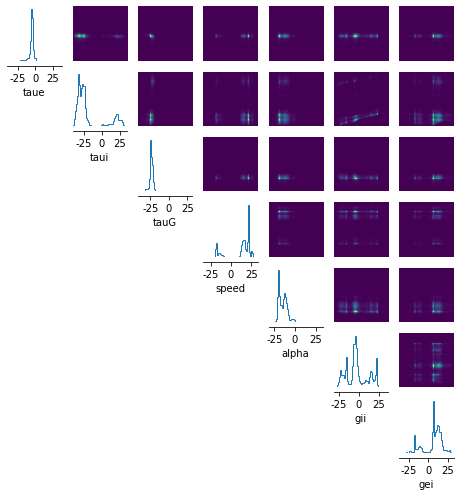

In [69]:
# taue, taui, tauC, speed, alpha, gii, gei
_ = analysis.pairplot(cur_res.post_spss_raw[0], 
                      #limits=paras.prior_bds,
                      labels=['taue','taui','tauG','speed','alpha','gii','gei'], 
                      figsize=(8,8))

In [70]:
# from theta_raw to theta
post_spss = [_theta_raw_2out(post_sps_raw, paras.prior_bds) for post_sps_raw in cur_res.post_spss_raw]

cur_res.post_spss = post_spss
save_pkl_dict2folder(_paras.folder_path, cur_res, is_force=False)

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam10000_sd15_denestnsf_embedFalse/posterior.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam10000_sd15_denestnsf_embedFalse/post_spss_raw.pkl exists! Use is_force=True to save it anyway
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam10000_sd15_denestnsf_embedFalse/post_spss.pkl


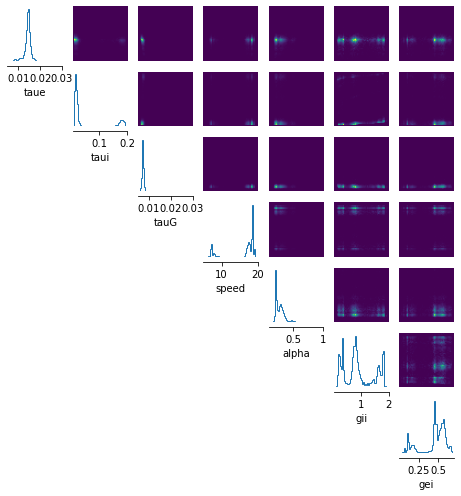

In [71]:
# taue, taui, tauC, speed, alpha, gii, gei
_ = analysis.pairplot(cur_res.post_spss[0], 
                      limits=paras.prior_bds,
                      labels=['taue','taui','tauG','speed','alpha','gii','gei'], 
                      figsize=(8,8))

#### PSD estimate

In [30]:
cur_res = load_pkl_folder2dict(_paras.folder_path, [""])

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds1_reparam100000_sd20_denestnsf_embedFalse/theta_raw.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds1_reparam100000_sd20_denestnsf_embedFalse/x.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds1_reparam100000_sd20_denestnsf_embedFalse/posterior.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds1_reparam100000_sd20_denestnsf_embedFalse/post_spss_raw.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds1_reparam100000_sd20_denestnsf_embedFalse/post_spss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds1_reparam100000_sd20_denestnsf_embedFalse/raw_sp.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds1_reparam100000_sd20_denestnsf_embedFalse/std_psd_DB.pkl


In [12]:
cur_res = load_pkl_folder2dict(_paras.folder_path, ["x", "*raw"])

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds1_reparam100000_sd20_denestnsf_embedFalse/posterior.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds1_reparam100000_sd20_denestnsf_embedFalse/post_spss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds1_reparam100000_sd20_denestnsf_embedFalse/raw_sp.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds1_reparam100000_sd20_denestnsf_embedFalse/std_psd_DB.pkl


In [73]:
# the estimated PSD and spatial feature from SGM  

# way 1
cur_est_parass = np.array([np.median(ps, axis=0) for ps in cur_res.post_spss])

# way 2
#cur_est_parass = np.array([[get_mode(ps[:, ix]) for ix in range(7)] for ps in cur_res.post_spss])

# way 3
#cur_est_parass_raw = np.array([np.median(ps, axis=0) for ps in cur_res.post_spss_raw])
#cur_est_parass = _theta_raw_2out(cur_est_parass_raw, paras.prior_bds)

# way 4
#cur_est_parass_raw = np.array([[get_mode(ps[:, ix]) for ix in range(7)] for ps in cur_res.post_spss_raw])
#cur_est_parass = _theta_raw_2out(cur_est_parass_raw, paras.prior_bds)

std_psd_DB = []
raw_sp = []
for ix in trange(36):
    cur_est_paras = cur_est_parass[ix, :]
    
    cur_conn = ind_conn[:, :, ix]
    cur_brain = Brain.Brain()
    cur_brain.add_connectome(DAT_ROOT) # grabs distance matrix
    cur_brain.reorder_connectome(cur_brain.connectome, cur_brain.distance_matrix)
    cur_brain.connectome = cur_conn# re-assign connectome to individual connectome
    cur_brain.bi_symmetric_c()
    cur_brain.reduce_extreme_dir()
    
    cur_SGM_model = SGM(cur_brain.reducedConnectome, cur_brain.distance_matrix, FREQS)
    cur_psd, cur_sp = cur_SGM_model.run_local_coupling_forward(cur_est_paras)
    cur_psd = cur_psd[:68, :]
    cur_psd_DB = psd_2tr(cur_psd)
    #cur_psd_DB = cur_psd_DB.reshape(68, 40)
    
    std_psd_DB.append(cur_psd_DB)
    raw_sp.append(cur_sp.sum(axis=1))
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:37<00:00,  1.05s/it]


In [74]:
sgm_psd_curve = np.array(std_psd_DB).mean(axis=1).mean(axis=0)
meg_psd_curve = np.mean([psd_2tr(ind_psd[:, :, ix]).mean(axis=0) for ix in range(36)], axis=0)
cor = scipy.stats.pearsonr(stdz_vec(meg_psd_curve), stdz_vec(sgm_psd_curve))[0]
print(f"Corr is {cor:.3f}")

Corr is 0.975


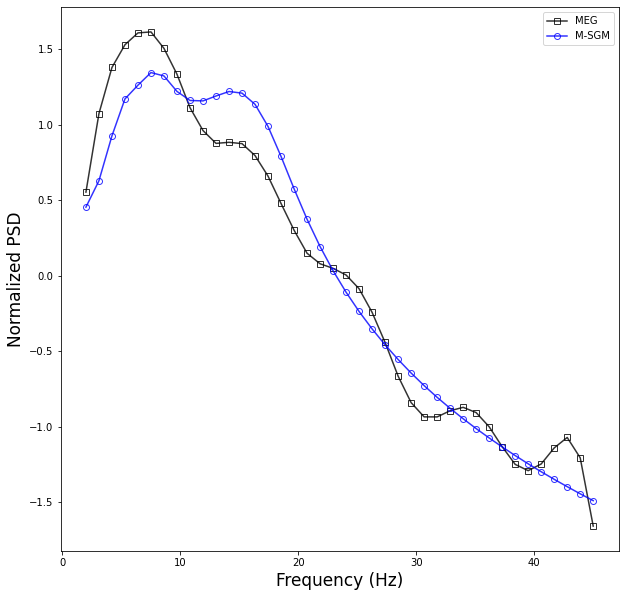

In [75]:
plt.figure(figsize=[10, 10])
#plt.plot(FREQS, meg_psd_curve, linestyle = '-',
plt.plot(FREQS, stdz_vec(meg_psd_curve), linestyle = '-',
         marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
#plt.plot(FREQS, sgm_psd_curve, linestyle = '-',
plt.plot(FREQS, stdz_vec(sgm_psd_curve), linestyle = '-',
         marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)
plt.legend()

In [76]:
# Corrs for PSD and spatial features for each subject
meg_psd_roi_sub = np.array([psd_2tr(ind_psd[:, :, ix]) for ix in range(36)])
sgm_psd_roi_sub = np.array(std_psd_DB)

corrs_roi_sub = []
for ix in range(meg_psd_roi_sub.shape[0]):
    cur_meg = meg_psd_roi_sub[ix]
    cur_sgm = sgm_psd_roi_sub[ix]
    corrs_roi_sub.append(np.mean([scipy.stats.pearsonr(cur_meg[iy], cur_sgm[iy])[0] for iy in range(68)]))
corrs_roi_sub = np.array(corrs_roi_sub)

In [77]:
np.sort(corrs_roi_sub)

array([0.7173805 , 0.722993  , 0.79056448, 0.80251312, 0.82048086,
       0.82814799, 0.83919684, 0.84140619, 0.8440395 , 0.85335558,
       0.85654131, 0.86042701, 0.8609725 , 0.86464841, 0.87247121,
       0.87299643, 0.8745338 , 0.87787556, 0.87907353, 0.88190835,
       0.88203201, 0.88235332, 0.88462613, 0.88761814, 0.89130804,
       0.8919449 , 0.89505809, 0.89728055, 0.90211391, 0.90304744,
       0.90333663, 0.90545618, 0.91592456, 0.91607247, 0.92147719,
       0.93254902])

In [78]:
print(np.median(corrs_roi_sub), np.mean(corrs_roi_sub))

0.8784745489182189 0.865936798774712


In [79]:
np.argsort(corrs_roi_sub)

array([32, 24,  4, 21, 35,  3, 18, 27, 34, 25, 31, 28, 14, 33,  9, 15,  1,
       13,  7, 20, 22, 11, 10,  0, 17, 23, 16, 26, 19,  8,  5, 30,  2,  6,
       12, 29])

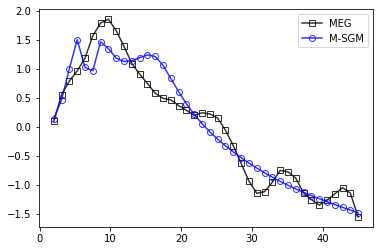

In [80]:
sub_ix = 1
cur_sgm.shape
plt.plot(FREQS, stdz_vec(meg_psd_roi_sub[sub_ix, :, :].mean(axis=0)), linestyle = '-',
         marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
plt.plot(FREQS, stdz_vec(sgm_psd_roi_sub[sub_ix, :, :].mean(axis=0)), linestyle = '-',
         marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
plt.legend()

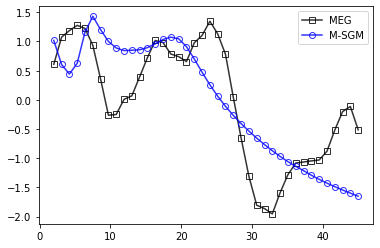

In [38]:
sub_ix = 24
roi_ix = 1
cur_sgm.shape
plt.plot(FREQS, stdz_vec(meg_psd_roi_sub[sub_ix, roi_ix, :]), linestyle = '-',
         marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
plt.plot(FREQS, stdz_vec(sgm_psd_roi_sub[sub_ix, roi_ix, :]), linestyle = '-',
         marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
plt.legend()

In [32]:
cur_res.raw_sp = raw_sp
cur_res.std_psd_DB = std_psd_DB
save_pkl_dict2folder(_paras.folder_path, cur_res, False)

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/generalNoiseRawReparam_20000_sd20_denestnsf_embedTrue/theta_raw.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/generalNoiseRawReparam_20000_sd20_denestnsf_embedTrue/x.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/generalNoiseRawReparam_20000_sd20_denestnsf_embedTrue/posterior.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/generalNoiseRawReparam_20000_sd20_denestnsf_embedTrue/embedding_net.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/generalNoiseRawReparam_20000_sd20_denestnsf_embedTrue/post_spss_raw.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/generalNoiseRawReparam_20000_sd20_denestnsf_embedTrue/post_spss.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/generalNoiseRawReparam_20000_sd20_denestnsf_embedTrue/raw_sp.pkl
Save to /data/rajlab1/u

### Another way to do the inference

In [15]:
all_post_psds = []
for ix in range(ind_psd.shape[-1]):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    cur_sgmmodel = SGM(curBrain.reducedConnectome, curBrain.distance_matrix, FREQS)
        
    sp, raw_sps = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, ix], FREQS, band="alpha")
    
    std_spv = stdz_vec(raw_sps.sum(axis=1))
    std_psd_DB = psd_2tr(ind_psd[:, :, ix])
    
    curX_raw = np.concatenate([std_psd_DB.flatten(), std_spv])
    curX = torch.Tensor(curX_raw)
    cur_post = cur_res.posterior.set_default_x(curX)
        
    simulator_data_sp = partial(simulator_data,  sgmmodel=cur_sgmmodel, prior_bds=paras.prior_bds)
    simulator_data_wrapper, _ = prepare_for_sbi(simulator_data_sp, prior)
    
    print(ix)
    tmp_sps, post_psd = simulate_for_sbi(simulator_data_wrapper, cur_post, 
                            num_simulations=100,
                            num_workers=50)
    _, post_psd_stable = _filter_unstable(tmp_sps, paras.prior_bds, post_psd)
    print(post_psd_stable.shape)
    all_post_psds.append(post_psd_stable.numpy())

0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([99, 2788])
1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([98, 2788])
2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([98, 2788])
4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([99, 2788])
5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([99, 2788])
15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([99, 2788])
17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([99, 2788])
19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([98, 2788])
20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([98, 2788])
22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([99, 2788])
25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([99, 2788])
32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])
33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([99, 2788])
34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([99, 2788])
35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2788])


In [16]:
est_psds = []
for post_psd in all_post_psds:
    est_psd = np.mean(post_psd[:, :-68], axis=0)
    est_psd = est_psd.reshape(68, 40)
    est_psds.append(est_psd)

In [17]:
sgm_psd_curve1 = np.array(est_psds).mean(axis=1).mean(axis=0)
meg_psd_curve = np.mean([psd_2tr(ind_psd[:, :, ix]).mean(axis=0) for ix in range(36)], axis=0)
cor = scipy.stats.pearsonr(stdz_vec(meg_psd_curve), stdz_vec(sgm_psd_curve1))[0]
print(f"Corr is {cor:.3f}")

Corr is 0.988


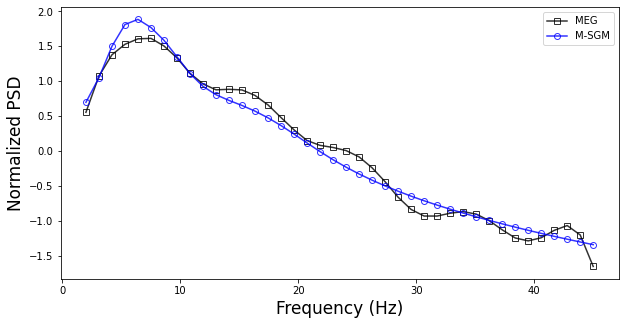

In [27]:
plt.figure(figsize=[10, 5])
#plt.plot(FREQS, meg_psd_curve, linestyle = '-',
plt.plot(FREQS, stdz_vec(meg_psd_curve), linestyle = '-',
         marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
#plt.plot(FREQS, sgm_psd_curve1, linestyle = '-',
plt.plot(FREQS, stdz_vec(sgm_psd_curve1), linestyle = '-',
         marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)
plt.legend()

In [19]:
# Corrs for PSD and spatial features for each subject
meg_psd_roi_sub = np.array([psd_2tr(ind_psd[:, :, ix]) for ix in range(36)])
sgm_psd_roi_sub = np.array(est_psds)

corrs_roi_sub1 = []
for ix in range(meg_psd_roi_sub.shape[0]):
    cur_meg = meg_psd_roi_sub[ix]
    cur_sgm = sgm_psd_roi_sub[ix]
    corrs_roi_sub1.append(np.mean([scipy.stats.pearsonr(cur_meg[iy], cur_sgm[iy])[0] for iy in range(68)]))
corrs_roi_sub1 = np.array(corrs_roi_sub1)

In [20]:
print(np.median(corrs_roi_sub1), np.mean(corrs_roi_sub1))

0.8995026023164818 0.8888607933473206


In [21]:
np.sort(corrs_roi_sub1)

array([0.73690229, 0.79820387, 0.82306468, 0.83413185, 0.83924807,
       0.8507294 , 0.86463387, 0.86626709, 0.87945358, 0.88734979,
       0.89004077, 0.89311355, 0.89329741, 0.89343455, 0.89558513,
       0.89711068, 0.8974626 , 0.89949358, 0.89951163, 0.89996198,
       0.90066383, 0.90148947, 0.90487846, 0.90625376, 0.90662056,
       0.9089943 , 0.91044905, 0.91200348, 0.91440885, 0.91477686,
       0.91980098, 0.92035963, 0.92556936, 0.93507996, 0.93834424,
       0.94029942])

In [22]:
np.argsort(corrs_roi_sub1)

array([24,  4, 21,  3, 18, 32, 25, 10,  7, 34, 14,  8, 11, 28, 15,  1,  9,
       17, 16,  0, 26, 23, 31, 35, 12, 19, 27,  2,  6, 33, 22,  5, 13, 20,
       29, 30])

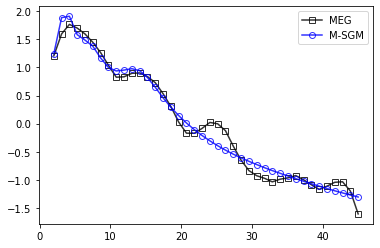

In [23]:
ix = 30 
sgm_post_rois = sgm_psd_roi_sub.mean(axis=1)
plt.plot(FREQS, stdz_vec(meg_psd_roi_sub[ix, :, :].mean(axis=0)), linestyle = '-',
         marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
plt.plot(FREQS, stdz_vec(sgm_post_rois[ix]), linestyle = '-',
         marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
plt.legend()